In [63]:
#%matplotlib inline
%matplotlib notebook

Define the network
------------------

general ref: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class LogRegNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        output = self.linear(x)
        probs = self.softmax(output)
        return probs

## Construct fake dataset (to classify as 0 or 1)

see: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [65]:
input_dim = 3
output_dim = 2

def build_gaussian_data(class_0_amount, class_1_amount):

    # makes gaussian blob with mean [1, 1, 1]
    mean_type_0 = 1 
    std_type_0 = 1.5
    blob_type_0 = torch.normal(mean=mean_type_0, 
                              std=std_type_0,
                              size=(class_0_amount, input_dim))
    labels_type_0 = torch.zeros(class_0_amount, dtype=torch.int64)

    # makes gaussian blob with mean [-2,-2,-2]
    mean_type_1 = -2
    std_type_1 = 2
    blob_type_1 = torch.normal(mean=mean_type_1, 
                              std=std_type_1,
                              size=(class_1_amount, input_dim))
    labels_type_1 = torch.ones(class_1_amount, dtype=torch.int64)

    # store in big dataset array, X, and label array, Y
    data_X = torch.cat((blob_type_0, blob_type_1))
    data_Y = torch.cat((labels_type_0, labels_type_1))
    
    return data_X, data_Y

X_train, Y_train = build_gaussian_data(1000, 200)
X_test, Y_test = build_gaussian_data(2000, 2000)

Force into standardized custom dataset class (to play nice with training)

In [66]:
class DataLogReg(Dataset):
    
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        self.input_dim = self.x.size()[1]
        
    # Mandatory: Get input pair for training
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]
    
    # Mandatory: Number of elements in dataset
    def __len__(self):
        X_len = self.x.size()[0]
        return X_len
    
    # This function is not needed
    def plot(self):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xs = self.x.numpy()[:, 0]
        ys = self.x.numpy()[:, 1]
        zs = self.x.numpy()[:, 2]
        ax.scatter(xs, ys, zs, c=self.y)
        ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
        plt.show()        

# specify training and testing datasets
train_dataset = DataLogReg(X_train, Y_train)
test_dataset = DataLogReg(X_test, Y_test)

<IPython.core.display.Javascript object>


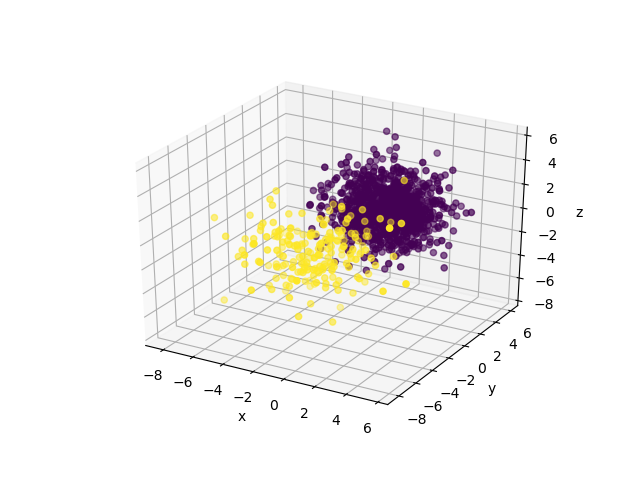

In [67]:
train_dataset.plot()

## Initialize the network class

In [68]:
net = LogRegNet(input_dim, output_dim)
print(net)

LogRegNet(
  (linear): Linear(in_features=3, out_features=2, bias=False)
  (softmax): Softmax(dim=1)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



## Inspect the network

In [69]:
params = list(net.parameters())
print('Num of params matrices to train:', len(params))
print(params[0].size())

Num of params matrices to train: 1
torch.Size([2, 3])


In [70]:
sample_input = torch.randn(1, input_dim)     # first dimension is the batch dimension when feeding to nn layers
features_out = net(sample_input)             # expect size batch_size x 2
print(features_out.size())
print(features_out)

torch.Size([1, 2])
tensor([[0.3496, 0.6504]], grad_fn=<SoftmaxBackward>)


Zero the gradient buffers of all parameters and backprops with random
gradients:



In [71]:
net.zero_grad()                           # set internal gradients to zero
features_out.backward(torch.randn(1, 2))  # effectively randomize the internal gradients? why do the docs do this?

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Choose a loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different loss functions https://pytorch.org/docs/nn.html#loss-functions under the nn package.

Here we use: ``nn.NLLLoss`` which computes the negative log-likelihood of the input data.
We could alternatively use ``nn.CrossEntropyLoss`` which wraps (a) the softmax layer, and (b) ``nn.NLLLoss``.

ref: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

In [72]:
criterion = nn.NLLLoss()

output = net(sample_input)
target = torch.tensor([1])      # a dummy target class in [0,1], for example
loss = criterion(output, target)
print(loss)

tensor(-0.6504, grad_fn=<NllLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

:: logistic regression network (guess)

    input -> linear -> softmax -> NLLLoss -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [73]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop example
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [74]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('net.linear.weight.grad before backward')
print(net.linear.weight.grad)

loss.backward()

print('net.linear.weight.grad after backward')
print(net.linear.weight.grad)

net.linear.weight.grad before backward
tensor([[0., 0., 0.],
        [0., 0., 0.]])
net.linear.weight.grad after backward
tensor([[-0.1688,  0.2610, -0.0031],
        [ 0.1688, -0.2610,  0.0031]])


Optimization: Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple Python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [75]:
# Training loop hyperparameters
batch_size = 20
epochs = 10
learning_rate = 0.001

# Choose an optimizer or create one
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# Setup data batching
nwork = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nwork)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nwork)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
########inputs, labels = data[0].to(device), data[1].to(device)  # what to send to deive? the Dataset object? 
print(device)

cpu


In [76]:
def report_test_error():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            samples, labels = data
            outputs = net(samples)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [77]:
for epoch in range(epochs):       # loop over the dataset multiple times
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data  # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 9
            print('Epoch: %d, batch: %5d, loss: %.3f' %
                  (epoch, i + 1, running_loss))
            report_test_error()
            running_loss = 0.0

print('Finished Training')

0
Epoch: 0, batch:    10, loss: -6.552
Accuracy of the network on the 10000 test images: 78 %
Epoch: 0, batch:    20, loss: -6.701
Accuracy of the network on the 10000 test images: 80 %
Epoch: 0, batch:    30, loss: -7.120
Accuracy of the network on the 10000 test images: 81 %
Epoch: 0, batch:    40, loss: -6.700
Accuracy of the network on the 10000 test images: 82 %
Epoch: 0, batch:    50, loss: -7.322
Accuracy of the network on the 10000 test images: 84 %
Epoch: 0, batch:    60, loss: -7.336
Accuracy of the network on the 10000 test images: 84 %
1
Epoch: 1, batch:    10, loss: -7.296
Accuracy of the network on the 10000 test images: 85 %
Epoch: 1, batch:    20, loss: -7.448
Accuracy of the network on the 10000 test images: 86 %
Epoch: 1, batch:    30, loss: -7.565
Accuracy of the network on the 10000 test images: 86 %
Epoch: 1, batch:    40, loss: -7.493
Accuracy of the network on the 10000 test images: 87 %
Epoch: 1, batch:    50, loss: -7.633
Accuracy of the network on the 10000 te

## Save Model

In [78]:
import os

models_dir = 'models'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)
    
model_path = models_dir + os.sep + 'net_logreg.pth'
torch.save(net.state_dict(), model_path)

## Load Model

In [79]:
dataiter = iter(test_loader)
samples, labels = dataiter.next()

net = LogRegNet(input_dim, output_dim)
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Assess loaded model (short check, then full dataset)

In [80]:
outputs = net(samples)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(4)))
print('True: ', ' '.join('%5s' % labels[j] for j in range(4)))

Predicted:  tensor(1) tensor(0) tensor(1) tensor(1)
True:  tensor(0) tensor(0) tensor(1) tensor(0)


In [81]:
report_test_error()

Accuracy of the network on the 10000 test images: 91 %


In [82]:
# TODO how to plot decision boundary/regions in 3d? 